<a href="https://colab.research.google.com/github/lucaskawazoi/lkk-xview2/blob/master/localization/create_tfrecords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
- https://www.tensorflow.org/tutorials/load_data/tfrecord#write_the_tfrecord_file
- https://cloud.google.com/tpu/docs/tutorials/mnist#download_and_convert_the_mnist_data
- /home/lucaskawazoi/development/professional/temp/tpu/models/official/mnist
- /home/lucaskawazoi/development/professional/lkk-xview2/localization

# Import libraries

In [1]:
# Import libraries
import os
from pathlib import Path

import numpy as np 
import math
import random

import cv2
from google.colab.patches import cv2_imshow

import tensorflow as tf
print('TF version:', tf.__version__)

TF version: 1.15.0


# Download data

In [2]:
# Authenticate and config credentials
! gcloud auth login
! gcloud config set project lkk-project-1

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=UWg2G8i2bN7tdbhZH7dhJdmdBXGFZiOc_RtlTsxFM64&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


Enter verification code: 4/uAEuRUTTynB_TD9KjWsX6Xl_xxefAhEL9w76xWdpdqPxYlma3kRkXDQ
If you need to use ADC, see:
  gcloud auth application-default --help

You are now logged in as [lucas.key.kawazoi@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].


In [0]:
# Set folder paths
PATH = Path()
images_folder = PATH / 'images'
images_folder.mkdir(exist_ok=True)

grayscale_labels_folder = PATH / 'grayscale_labels'
grayscale_labels_folder.mkdir(exist_ok=True)

dataSet_folder = PATH / 'dataSet'
dataSet_folder.mkdir(exist_ok=True)

tfrecords_folder = PATH / 'tfrecords'
tfrecords_folder.mkdir(exist_ok=True)

In [0]:
# Download data
# ! gsutil -m rsync -r gs://lkk-xview2/xBD/spacenet_gt/images {images_folder}
# ! gsutil -m rsync -r gs://lkk-xview2/xBD/spacenet_gt/grayscale_labels {grayscale_labels_folder}
# ! gsutil -m rsync -r gs://lkk-xview2/xBD/spacenet_gt/dataSet {dataSet_folder}

In [39]:
# List files
images_list = sorted(images_folder.iterdir())
grayscale_labels_list = sorted(grayscale_labels_folder.iterdir())

dataset = 'val'
with open(dataSet_folder/ '{}.txt'.format(dataset), 'r') as f:
    filenames = [line.strip() for line in f]
print(len(images_list), len(grayscale_labels_list), dataset, ':', len(filenames))

2283 2283 val : 571


# Take a look at some images

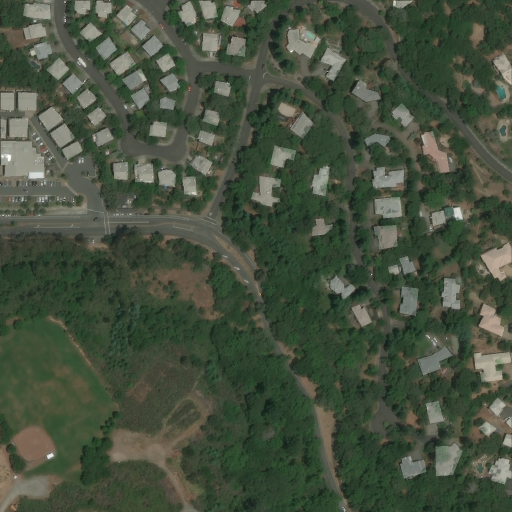

In [6]:
# Take a look at some images
img_example = random.choice(images_list)
def show_img_from_png(img_example, scale_factor=2):
  label_example = grayscale_labels_folder / img_example.name
  image = cv2.imread(str(img_example))
  label = cv2.imread(str(label_example))
  height = image.shape[0]
  width = image.shape[1]
  combined = cv2.addWeighted(image, 0.8, label, 0.2, 0) 
  combined = cv2.resize(combined, (math.ceil(height/scale_factor), math.ceil(width//scale_factor)))
  cv2_imshow(combined)

show_img_from_png(img_example, 2)

# Create tf.Example

In [0]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [0]:
# Create tf.Example
def image_example(image_path):
  label_path = grayscale_labels_folder / image_path.name

  # Get filenames
  image_filename = image_path.name.encode('utf-8')
  label_filename = label_path.name.encode('utf-8')
  
  # Open image and label as arrays
  image = cv2.imread(str(image_path))
  label = cv2.imread(str(label_path))
  # print('Type image:', type(image))

  image_string = cv2.imencode('.png', image)[1].tobytes()
  label_string = cv2.imencode('.png', label)[1].tobytes()
  # print('Type image_string:', type(image_string))

  image_shape = image.shape
  # print('Image shape:', image_shape)

  feature = {
      'image_encoded': _bytes_feature(image_string),
      'image_filename': _bytes_feature(image_filename),
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label_encoded': _bytes_feature(label_string),
      'label_filename': _bytes_feature(label_filename),
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))

image_path = random.choice(images_list)
image_example(image_path)

# Create tfrecords using TFRecordWriter

In [0]:
# Set variables (run the cells below for each dataset: 'train' and 'val')
_NUM_SHARDS = 4
dataset = 'train'

In [0]:
# Get filenames
with open(dataSet_folder/ '{}.txt'.format(dataset), 'r') as f:
    filenames = [images_folder / line.strip() for line in f]

In [11]:
# Count number of files per shard / file
num_images = len(filenames)
num_per_shard = int(math.ceil(num_images / _NUM_SHARDS))

for shard_id in range(_NUM_SHARDS):
  tfrecords_filename = tfrecords_folder / '{}-{:05d}-of-{:05d}.tfrecord'.format(dataset, shard_id, _NUM_SHARDS)
  with tf.python_io.TFRecordWriter(str(tfrecords_filename)) as tfrecord_writer:
    start_idx = shard_id * num_per_shard
    end_idx = min((shard_id + 1) * num_per_shard, num_images)
    print('\r>> Converting images {}-{} (of {}). shard {}'.format(start_idx, end_idx, len(filenames), shard_id))
    for i in range(start_idx, end_idx):
      # Read the image.
      image_path = filenames[i]
      tf_example = image_example(image_path)
      tfrecord_writer.write(tf_example.SerializeToString())

>> Converting images 0-143 (of 571). shard 0
>> Converting images 143-286 (of 571). shard 1
>> Converting images 286-429 (of 571). shard 2
>> Converting images 429-571 (of 571). shard 3


# Upload tfrecords

In [0]:
# Upload data
! gsutil -m rsync -r {tfrecords_folder} gs://lkk-xview2/xBD/spacenet_gt/tfrecords 

Building synchronization state...
Starting synchronization...


TFrecords created! Great!

# Read tfrecords
Now, lets download and read it!

Download > Read into TFRecordDataset > parse > get example > decode

In [12]:
# Download data
! gsutil -m rsync -r gs://lkk-xview2/xBD/spacenet_gt/tfrecords {tfrecords_folder}

Building synchronization state...
Starting synchronization...
Copying gs://lkk-xview2/xBD/spacenet_gt/tfrecords/train-00000-of-00004.tfrecord...
Copying gs://lkk-xview2/xBD/spacenet_gt/tfrecords/train-00003-of-00004.tfrecord...
Copying gs://lkk-xview2/xBD/spacenet_gt/tfrecords/train-00002-of-00004.tfrecord...
Copying gs://lkk-xview2/xBD/spacenet_gt/tfrecords/val-00003-of-00004.tfrecord...
Copying gs://lkk-xview2/xBD/spacenet_gt/tfrecords/train-00001-of-00004.tfrecord...
Copying gs://lkk-xview2/xBD/spacenet_gt/tfrecords/val-00001-of-00004.tfrecord...
Copying gs://lkk-xview2/xBD/spacenet_gt/tfrecords/val-00000-of-00004.tfrecord...
Copying gs://lkk-xview2/xBD/spacenet_gt/tfrecords/val-00002-of-00004.tfrecord...
\ [8/8 files][  3.8 GiB/  3.8 GiB] 100% Done  13.5 MiB/s ETA 00:00:00           
Operation completed over 8 objects/3.8 GiB.                                      


In [42]:
# Read the files into dataset
raw_dataset = tf.data.TFRecordDataset([str(f) for f in tfrecords_filenames])
raw_dataset

# Parse the dataset
feature_description = {
    'image_encoded': tf.io.FixedLenFeature([], tf.string),
    'image_filename': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label_encoded': tf.io.FixedLenFeature([], tf.string),
    'label_filename': tf.io.FixedLenFeature([], tf.string),
}

def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<DatasetV1Adapter shapes: {depth: (), height: (), image_encoded: (), image_filename: (), label_encoded: (), label_filename: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_encoded: tf.string, image_filename: tf.string, label_encoded: tf.string, label_filename: tf.string, width: tf.int64}>

In [43]:
# Let's read one example to check if everything went fine!
def get_example(parsed_dataset):
  iterator = parsed_dataset.make_one_shot_iterator()
  next_element = iterator.get_next()
  with tf.Session() as sess:
    for i in range(100):
      example = sess.run(next_element)
  return example

example = get_example(parsed_dataset)

OutOfRangeError: ignored

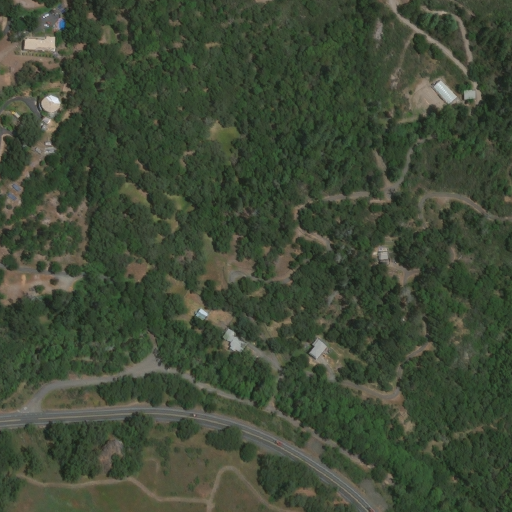

In [44]:
# Show image
def show_img_from_parsed_example(example, scale_factor=2):
  image_nparray = np.frombuffer(example['image_encoded'], np.uint8)
  label_nparray = np.frombuffer(example['label_encoded'], np.uint8)
  image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
  label = cv2.imdecode(label_nparray, cv2.IMREAD_COLOR)
  height = image.shape[0]
  width = image.shape[1]
  combined = cv2.addWeighted(image, 0.8, label, 0.2, 0) 
  combined = cv2.resize(combined, (math.ceil(height/scale_factor), math.ceil(width//scale_factor)))
  cv2_imshow(combined)

show_img_from_parsed_example(example, 2)

# Create tf.data.TFRecordDataset

In [45]:
# Get desired filenames
tfrecords_filenames = sorted(tfrecords_folder.rglob('**/{}-*.tfrecord'.format(dataset)))
tfrecords_filenames = [str(f) for f in tfrecords_filenames]
print(len(tfrecords_filenames))

def create_dataset(tfrecords_filenames):
  feature_description = {
    'image_encoded': tf.io.FixedLenFeature([], tf.string),
    'image_filename': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label_encoded': tf.io.FixedLenFeature([], tf.string),
    'label_filename': tf.io.FixedLenFeature([], tf.string),
    }
  def decode_record(record):
    example = tf.io.parse_single_example(record, feature_description)
    
    # image_nparray = np.frombuffer(example['image_encoded'], np.uint8)
    # image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
    image = tf.decode_raw(example['image_encoded'], tf.uint8)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [1024, 1024, 3])

    # label_nparray = np.frombuffer(example['label_encoded'], np.uint8)
    # label = cv2.imdecode(label_nparray, cv2.IMREAD_COLOR)
    label = tf.decode_raw(example['label_encoded'], tf.uint8)
    label = tf.cast(label, tf.float32)
    label = tf.reshape(label, [1024, 1024, 1])
    return image, label

  return tf.data.TFRecordDataset(tfrecords_filenames).map(decode_record)

create_dataset(tfrecords_filenames)

4


<DatasetV1Adapter shapes: ((1024, 1024, 3), (1024, 1024, 1)), types: (tf.float32, tf.float32)>

# Create input function to feed TPUestimator

In [0]:
def train_input_fn(batch_size, tfrecords_filenames):
  """train_input_fn defines the input pipeline used for training."""
  # batch_size = params['batch_size']
  # tfrecords_filenames = params['tfrecords_folder'] / "train.tfrecords")

  return create_dataset(tfrecords_filenames).cache().repeat().shuffle(
      buffer_size=4000).batch(batch_size, drop_remainder=True)

In [50]:
batch_size = 128
train_input_fn(batch_size, tfrecords_filenames)

<DatasetV1Adapter shapes: ((128, 1024, 1024, 3), (128, 1024, 1024, 1)), types: (tf.float32, tf.float32)>

# The end